# Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

root = 'C:/Apoorva/Masters - Business Analytics/Masters MSBA/4th SEMESTER/Capstone/instacart-market-basket-analysis/' 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [4]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [5]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4428.972461700439  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1293.1306457519531  MB
This is  29.197080291970803 % of the initial size


In [6]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [7]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0


In [8]:
df.shape

(8474661, 70)

In [9]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [10]:
X = df[x_cols]
y = df[label]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 69) (6355995,)
(2118666, 69) (2118666,)


In [12]:
y_train.value_counts()

0.0    5734377
1.0     621618
Name: reordered, dtype: int64

In [13]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [14]:
y_test.value_counts()

0.0    1911460
1.0     207206
Name: reordered, dtype: int64

In [15]:
# freeing memory
del df, X, y
gc.collect()

34

## Neural Network model 

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [17]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [18]:
input_dim =  X_train_sc.shape[1]
input_dim

69

In [19]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
history = History()

classifier = Sequential()

classifier.add(Dense(units = 64, activation = 'relu', input_dim = input_dim))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 1, activation ='sigmoid'))

classifier.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy', f1_m, precision_m, recall_m])

classifier.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4480      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 64        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 5,524
Trainable params: 5,524
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
# fit the model
classifier.fit(X_train_sc, y_train, epochs=50, batch_size=512, validation_split=0.15, verbose=1,class_weight= {0:1, 1:10},
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0, patience=10, verbose=0, mode='auto')])

Train on 5402595 samples, validate on 953400 samples
Epoch 1/50
5402595/5402595 [==============================] - 251s 46us/step - loss: 0.9395 - acc: 0.7416 - f1_m: 0.3681 - precision_m: 0.2428 - recall_m: 0.7720 - val_loss: 0.9379 - val_acc: 0.7310 - val_f1_m: 0.3612 - val_precision_m: 0.2357 - val_recall_m: 0.78352 - acc: 0.7416 - f1_m: 0.3682 - precision_m: 0.2428 - recall_m: 0.7 - ETA: 1:26 - loss: 0.9392 - acc: 0.7416 - f1_m: 0.3681 - precision_m: 0.2428 - recall_ - ETA: 1:25 - loss: 0.9392 - acc: 0.7416 - f1_m: 0.3681 - precision_m: 0.2428 - recall_m: 0.772 - ETA: 1:25 - loss: 0.9392 - acc: 0.7416 - f1_m: 0.3681 - precision_m: 0.2428 - recall_m: 0. - ETA: 1:25 - loss: 0.9393 - acc: 0.7416 - f1_m: 0.3681 - precision_m: 0.2427 - - ETA: 1:24 - loss: 0.9393 - acc: 0.7416 - f1_m: 0.3681 - precision_m: 0.2428 - recall_m - ETA: 1:24 - loss: 0.9394 - acc: 0.7415 - f1_m: 0.3681 - precision_m: 0.2427 - recall_m: 0.77 - ETA: 1:24 - loss: 0.9394 - acc: 0.7415 - f1_m: 0.3681 - precision_m: 

5402595/5402595 [==============================] - 154s 29us/step - loss: 0.9392 - acc: 0.7414 - f1_m: 0.3678 - precision_m: 0.2426 - recall_m: 0.7719 - val_loss: 0.9379 - val_acc: 0.7312 - val_f1_m: 0.3615 - val_precision_m: 0.2358 - val_recall_m: 0.7838: 0.7435 - f1_m: 0.3708 - precision_m: 0. - ETA: 2:20 - loss: 0.9381 - acc: 0.7434 - f1_m: 0.3693 - precision_m: 0.2438 -  - ETA: 2:20 - loss: 0.9388 - acc: 0.7428 - f1_m: 0.3694 - precision_m: 0.2438 - recall_m: 0.77 - ETA: 2:20 - loss: 0.9395 - acc: 0.7429 - f1_m: 0.3696 - precision_m: 0.2441 - recall_m: 0. - ETA: 2:19 - loss: 0.9399 - acc: 0.7429 - f1_m: 0.3695 - precision_m: 0.2440 - recall_m: - ETA: 2:21 - loss: 0.9401 - acc: 0.7423 - f1_m: 0.3693 - precision_m: 0.2438 - recall_m - ETA: 2:21 - loss: 0.9412 - acc: 0.7424 - f1_m: 0.3691 - precision_m: 0.2437 - re - ETA: 2:15 - loss: 0.9419 - acc: 0.7422 - f1_m: 0.3685 - precision_m: 0.2433 - recall_m: 0.770 - ETA: 2:16 - loss: 0.9419 - acc: 0.7422 - f1_m: 0.3685 - precision_m: - ETA

5402595/5402595 [==============================] - 136s 25us/step - loss: 0.9393 - acc: 0.7415 - f1_m: 0.3680 - precision_m: 0.2427 - recall_m: 0.7721 - val_loss: 0.9383 - val_acc: 0.7568 - val_f1_m: 0.3757 - val_precision_m: 0.2512 - val_recall_m: 0.7543 0.3742 - precision_m: 0.2472  - ETA: 5:48 - loss: 0.9295 - acc: 0.7453 - f1_m: 0.3730 - precision_m: 0.2467 - recall_m: 0.775 - ETA: 5:45 - loss: 0.9282 - acc: 0.7456 - f1_m: 0.3737 - precision_m: - ETA: 4:14 - loss: 0.9381 - acc: 0.7413 - f1_m: 0.3706 - precisi - ETA: 3:14 - lo - ETA: 2:20 - loss: 0.9365 - acc: 0.7423 - f1_m: 0.3683 - precision_m: 0.2428 - ETA: 1:58 - loss: 0.9381 - a - ETA: 1:49 - loss: 0 - ETA: 19s - loss: 0.9396 - acc: 0.7414 - f1_m: 0.3678 - precision_m: 0.2425 - recall_m: 0. - ETA: 19s - loss: 0.9397 - acc: 0. - ETA: 18s - loss: 0.93 - ETA: 10s - loss: 0.9395 - acc: 0.7414 - f1_m: 0.3679 - precision_m: 0.2425 - recall_m: 0.77 - ETA: 10s - loss: 0.9395 - acc: 0.7414 - f1_m: 0.3679 - precision_m: 0.2425 -  - ETA: 

5402595/5402595 [==============================] - 129s 24us/step - loss: 0.9391 - acc: 0.7415 - f1_m: 0.3680 - precision_m: 0.2426 - recall_m: 0.7721 - val_loss: 0.9372 - val_acc: 0.7510 - val_f1_m: 0.3724 - val_precision_m: 0.2475 - val_recall_m: 0.76111_m: 0.3688 - - ETA: 1:41 - loss: 0.9384 - acc: 0.7415 - f1_m: 0.3682 - precision_m: 0.2428 - recall - ETA: 1:42 - loss: 0.9385 - acc:  - ETA: 1: - ETA: 1:30 - loss: 0.9378 - acc: 0.7421 - f1_m: 0.3689 - precision_m: 0.2432 - recall_m: 0.773 - ETA: 1:30 - l - ETA: 1:25 - loss: 0.9376 - acc: 0.7422 - f1_m: 0.3690 - precision_m: 0.2433 - recall_m:  - ETA: 1:25 - loss: 0.9376 - acc: 0.7421 - f1_m: 0.3690 - precision_m: 0.2433 - recall_m: 0 - ETA: 1:25 - loss: 0.9378 - acc: 0.7421 - f1_m: 0.3689 - precision_m: 0.2432 - reca - ETA: 1:25 - loss: 0.9377 - acc: 0.7421 - f1_m: 0.3687 - preci - ETA: 1:26 - loss: 0.9380 - acc: 0.7421 - f1_m: 0.3688 - precision_m: 0.2432 - recall_m: 0.773 - ETA: 1:26 - loss: 0.9379 -  - ETA: 4s - loss: 0.9384 - ac

5402595/5402595 [==============================] - 139s 26us/step - loss: 0.9390 - acc: 0.7414 - f1_m: 0.3679 - precision_m: 0.2425 - recall_m: 0.7720 - val_loss: 0.9388 - val_acc: 0.7590 - val_f1_m: 0.3769 - val_precision_m: 0.2526 - val_recall_m: 0.7513s: 0.9385 - acc: 0.7419 - f1_m: 0.3706 - precision_m: 0.2446 - recal - ETA: 1:53 - loss: 0.9385 - acc: 0.7420 - f1_m: 0.3706 - precision_m: 0.2446 - reca - ETA: 1:53 - loss: 0.9387 - acc: 0.7420 - f1_m: 0.3705 - precision_m: 0.2445 - recall_m - ETA: 1:52 - loss: 0.9390 - acc: 0.7418 - f1_m: 0.3701 - p - ETA: 1:49 - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3699 - precision - ETA: 1:47 - loss: 0.9388 - acc: 0.7417 - f1_m: 0.3697 - precision_m: 0.24 - ETA: 1:47 - loss: 0 - ETA: 1:43 - loss: 0.9387 - acc: 0.7415 - f1_m: 0.3690 - precision_m: 0.2434 - re - ETA: 1:43 - loss: 0.9388 - acc: 0.7414 - f1_m: 0.3689 - - ETA: 1:42 - loss: 0.9388 - acc: 0.7415 - f1_m: 0.3689 - precision_m: 0.2433 - recall_m: 0.7 - ETA: 1:42 - loss: 0.9387 - acc: 0.7415 

5402595/5402595 [==============================] - 142s 26us/step - loss: 0.9390 - acc: 0.7414 - f1_m: 0.3680 - precision_m: 0.2426 - recall_m: 0.7726 - val_loss: 0.9368 - val_acc: 0.7396 - val_f1_m: 0.3661 - val_precision_m: 0.2407 - val_recall_m: 0.7747 - ETA: 39s - loss: 0.9387 - acc: 0.7408 - f1_m: 0.3680 - precis - ETA: 39s - loss: 0.9386 - acc: 0.7409 - f1_m: 0.3680 - precision_m: 0.2425 - recall_m: 0. - ETA: 39s - loss: 0.9386 - acc: 0.7409 - f1_m: 0.3680 - precision_m: 0.2425 - re - ETA: 39s - loss: 0.9386 - acc: 0.7409 - f1_m: 0.3679 - precision_m: 0.2425 - reca - ETA: 39s - loss: 0.9386 - acc: 0.7409 - f1_m: 0.3679 - precision_m: 0.2425 - recall_m:  - ETA: 39s - loss: 0.9387 - acc: 0.7409 - f1_m: 0.3679 - precision_m: 0.2425 - recall_m: 0. - ETA: 39s - loss: 0.9386 - acc: 0.7409 - f1_m: 0.3680 - precision_m: 0.2 - ETA: 39s - loss - ETA: 32s - loss: 0.9388 - acc: 0.7409 - f1_m: 0.3679 - precisio - ETA: 31s - loss: 0.9388 - acc: 0.7409 - f1_m: 0.3679 - precision_m: 0.2425 - rec

5402595/5402595 [==============================] - 148s 27us/step - loss: 0.9388 - acc: 0.7419 - f1_m: 0.3683 - precision_m: 0.2430 - recall_m: 0.7718 - val_loss: 0.9374 - val_acc: 0.7377 - val_f1_m: 0.3650 - val_precision_m: 0.2395 - val_recall_m: 0.77677 - acc: 0.7408 - f1_m: 0.3672 - precision_m: 0.2419 - re - ETA: 1:20 - loss: 0.9398 - acc: 0.7407 - f1_m: 0.3670 - precision_m: 0.2 - ETA: 1:20 - loss: 0.9396 - acc: 0.7408 - f1_m: 0.3669 - precision_m: 0.2418 -  - ETA: 1:19 - loss: 0.9399 - acc: 0.7405 - f1_m: 0.3668 - precision_m: 0.2416 - recall_m: - ETA: 1:19 - loss: 0.9401 - acc: 0.7404 - f1_m: 0.3667 - precision_m: 0.2416 - rec - ETA: 1:19 - loss: 0.9399 - acc: 0.740 - ETA: 1:17 - loss: 0.9401 - acc: 0.74 - ETA: 1:15 - loss: 0.9403 - acc: 0.7404 - f1_m: 0.3674 - precision_m: 0.24 - ETA: 1:14 - loss: 0.9403 - acc: 0.7405 - f1_m: 0.3674 - precision_m: 0.2421 - recall_m: 0 - ETA: 1:13 - loss: 0.9404 - acc: 0.7404 - f1_m: 0.3675 - precision_m:  - ETA: 1:12 - loss: 0.9400 - acc: 0.74

3262464/5402595 [=================>............] - ETA: 1:01 - loss: 0.9389 - acc: 0.7420 - f1_m: 0.3690 - precision_m: 0.2434 - recall_m: 0.7730- ETA: 2:23 - loss: 0.9445 - acc: 0.7412 - f1_m: 0.3671 - precision_m: 0.2425 - recall_m: 0.76 - ETA: 2:29 - loss: 0.9445 - acc: 0.7409 - f1_m: 0.3671 - pr - ETA: 2:31 - loss: 0.9440 - acc: 0.7417 - f1_m: 0.3685 - precision_m: 0.2435 - recall_m: 0.77 - ETA: 2:31 - loss: 0.9441 - acc: 0.7417 - f1_m: 0.3688 - precis - ETA: 2:24 - loss: 0.9420 - acc: 0.7420 - f1_m: 0.3711 - precision_m:  - ETA: 2:10 - loss: 0.9393 - acc: 0.7415 - f1_m: 0.3696 - precision_m: 0.2440 - recall_m: 0 - ETA: 2:09 - loss: 0.9397 - acc: 0.7415 - f1_m: 0.3697 - precision_m: 0.2441 - recall_m: - ETA: 2:08 - loss: 0.9404 - acc: 0.7411 - f1_m: 0.3695 - precision_m: 0.2439 - recall_m: 0 - ETA: 2:08 - loss: 0.9404 - acc: 0.7410 - f1_m: 0.3695 - precision_m: 0.2439 - recall_m:  - ETA: 2:07 - loss: 0.9400 - acc: 0.7411 - f1_m: 0.3699 - precision_m: 0.2441 - recall - ETA: 2:06 - l

5402595/5402595 [==============================] - 168s 31us/step - loss: 0.9388 - acc: 0.7418 - f1_m: 0.3683 - precision_m: 0.2429 - recall_m: 0.7723 - val_loss: 0.9372 - val_acc: 0.7462 - val_f1_m: 0.3696 - val_precision_m: 0.2445 - val_recall_m: 0.7668s - loss: 0.9395 - acc: 0.7417 - f1_m: 0.368 - ETA: 52s - loss: 0. - ETA: 51s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3685 - precision_m: 0.2430 - re - ETA: 50s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3685 - precision_m: 0.2430 - recall_m: 0. - ETA: 50s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3685 - precisio - ETA: 49s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3684 - precision_m: 0.2430 - recall_m: 0. - ETA: 49s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3685 - precision_m: 0.2430 - recall_m: 0. - ETA: 49s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3685 - prec - ETA: 49s - loss: 0.9392 - acc: 0.7418 - f1_m: 0.3685 - precision_m: - ETA: 48s - loss: 0.9394 - acc: 0.7417 - f1_m: 0.3685 - pr - ETA: 48s - loss: 0.9393 - acc: 0.7417 - f1_m: 0.3685 - preci

5402595/5402595 [==============================] - 154s 28us/step - loss: 0.9388 - acc: 0.7416 - f1_m: 0.3682 - precision_m: 0.2428 - recall_m: 0.7722 - val_loss: 0.9371 - val_acc: 0.7430 - val_f1_m: 0.3679 - val_precision_m: 0.2426 - val_recall_m: 0.77049352 - acc: 0.7414 - f1_m: 0.3709 - precision_m: 0.2444 - recall_m: 0.7 - ETA: 3:43 - loss: 0.9338 - acc: 0.7417 - f1_m: 0.3716 - precision_m: 0.2448 - recall_m: 0. - ETA: 3:43 - loss: 0.9349 - acc: 0.7427 - f1_m: 0.3727 -  - ETA: 3:23 - loss: 0.9350 - acc: 0.7440 - f1_m: 0.3717 - precision_m: 0.2455 - recall_m: 0.7 - ETA: 3:23 - loss: 0.9350 - acc: 0.7440 - f1_m: 0.3721 - precis - ETA: 3:09 - loss: 0.9362 - acc: 0.7431 - f1_m: 0.3717 - precision_m: 0.2455 - recall_m: - ETA: 3:07 - loss: 0.9342 - acc: - ETA: 2:47 - loss: 0.9391 - acc: 0.7414 -  - ETA: 2:35 - loss: 0.9397 - acc: 0.7402 - f1_m: 0.3699 - precision_m: 0.2439 - recall_m: 0. - ETA: 2:35 - loss: 0.9396 - acc: 0.7403 - f1_m: 0.3701 - precision_m: 0.2441 - recall_m: - ETA: 2:33

5402595/5402595 [==============================] - 156s 29us/step - loss: 0.9388 - acc: 0.7419 - f1_m: 0.3682 - precision_m: 0.2429 - recall_m: 0.7716 - val_loss: 0.9373 - val_acc: 0.7436 - val_f1_m: 0.3680 - val_precision_m: 0.2428 - val_recall_m: 0.7691all_m: 0.76 - ETA: 2:12 - loss: 0.9418 - acc: 0.7422 - f1_m: 0.3675 - precision_m: 0.2426 - rec - ETA: 2:09 - loss: 0. - ETA: 2:00 - loss: 0.9405 - acc: 0.7417 - f1_m: 0.3680  - ETA: 2:11 - loss: 0.9393 - acc: 0.7422 - f1_m: 0.3677 - precision_m: 0.2426 - recall_m: 0.77 - ETA: 2:12 - loss: 0.9395 - acc: 0.7423 - f1_m: 0.3677 - precision_m: 0.2426 - rec - ETA: 2:16 - loss: 0.9400 - acc: 0.7419 - f1_m: 0.3673 - precision_m: 0.2423 - recall_m: - ETA: 2:18 - loss: 0.9397 - acc: 0.7422 - f1_m: 0.3676 - precision_m: 0.2426 - recall_ - ETA: 2:21 - loss: 0.9394 - acc: 0.7421 - f1_m: 0.367 - ETA: 2:39 - loss: 0.9379 - acc: 0.7435 - f1_m: 0.3684 - precision_m: 0.2432 - recall_m: 0.770 - ETA: 2:39 - loss: 0.9380 - acc: 0.7435 - f1_m: 0.3683 - pre

In [28]:
eval_model=classifier.evaluate(X_train_sc, y_train)
print('loss: ', eval_model[0], 'and Accuracy: ', eval_model[1])

6355995/6355995 [==============================] - 349s 55us/step
loss:  0.5154577062432066 and Accuracy:  0.7443995786654586


Text(0.5, 1.0, 'Loss')

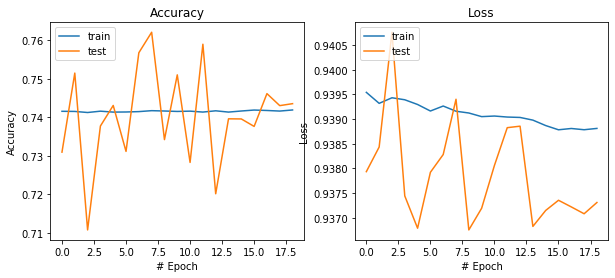

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_title('Loss')


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.24      0.77      0.37    207206

    accuracy                           0.74   2118666
   macro avg       0.61      0.75      0.60   2118666
weighted avg       0.90      0.74      0.79   2118666

Accuracy   Score :  0.744371694264221
F1 Score:  0.3699125936973925
Area under curve :  0.834558224044478 



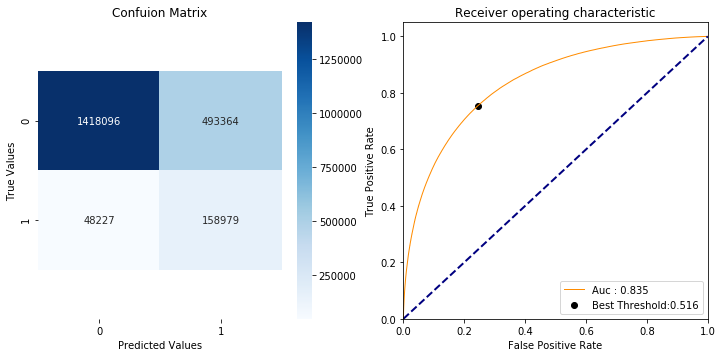

In [30]:
probabilities = classifier.predict_proba(X_test_sc)
predictions = classifier.predict_classes(X_test_sc)

print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probabilities) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()